In [1]:
import PIL
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from face_alignment import FaceAlignment, LandmarksType
import os

In [2]:
# rootPath = '../../dataForFewShotTalkingHeadModel/train/mp4/'
# personList = os.listdir(rootPath)
# for i, personId in enumerate(personList):
#     videoList = os.listdir(os.path.join(rootPath, personId))
#     for videoId in videoList:
#         videoFiles = os.listdir(os.path.join(rootPath, personId, videoId))
#         for video in videoFiles:
#             print(f'person ID: {i}, path ', os.path.join(rootPath, personId, videoId, video))

In [9]:
def generateVideoList(rootDir):
    """
    Generate a list of video paths, store personId as index
    :param folderPath: root path for all the video files
    :return: a list of video paths
    """
    videoList = []
    
    personList = os.listdir(rootDir)
    for i, personId in enumerate(personList):
        videoListPerPerson = os.listdir(os.path.join(rootDir, personId))
        for videoId in videoListPerPerson:
#             print(videoId)
#             print("*"*8)
            videoFiles = os.listdir(os.path.join(rootDir, personId, videoId))
            for video in videoFiles:
                videoList.append({"personId":i, "videoPath":os.path.join(rootDir, personId, videoId, video)})
    return videoList


def selectKRandomFramesForSpecificVideo(K, filePath):
    """
    Random select K frames from all the frame of the video
    :param K: Number of frames that we want to withdraw
    :param filePath: video path
    :param randomSeed: if we set the randomSeed, each epoch we will get the same frame from the same video, if the randomSeed is none, then different frames.
    :return: K random selected frames
    """
    cap = cv2.VideoCapture(filePath)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    randomIndex = np.random.choice(total, K)

    selectedFrames = []

    for index in randomIndex:
        # After this setting, we could get index'th frame by cap.read each time.
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        selectedFrames.append(frame)

    cap.release()
    return selectedFrames


def generateLandmarksForSpecificVideo(frames, fa):
    """
    Generate landmark frames for input frames
    :param frames:
    :param fa: face-alignment.FaceAlignment object
    :return: a list of landmark frames, [K, H, W, 3]
    """

    def generateLandmarkForSpecificFrame(frame, landmark):
        """
        Get the landmark frame by drawing the figure, then we store the figure in a [H, W, 3] data.
        :param frame:
        :param landmark: landmark generated by fa, landmark is [x, y] format.
        :return:
        """
        fig = plt.figure(figsize=(frame.shape[1] / 100, frame.shape[0] / 100), dpi=100)
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(np.ones(frame.shape))
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        # Head
        ax.plot(landmark[0:17, 0], landmark[0:17, 1], linestyle='-', color='green', lw=2)
        # Eyebrows
        ax.plot(landmark[17:22, 0], landmark[17:22, 1], linestyle='-', color='orange', lw=2)
        ax.plot(landmark[22:27, 0], landmark[22:27, 1], linestyle='-', color='orange', lw=2)
        # Nose
        ax.plot(landmark[27:31, 0], landmark[27:31, 1], linestyle='-', color='blue', lw=2)
        ax.plot(landmark[31:36, 0], landmark[31:36, 1], linestyle='-', color='blue', lw=2)
        # Eyes
        ax.plot(landmark[36:42, 0], landmark[36:42, 1], linestyle='-', color='red', lw=2)
        ax.plot(landmark[42:48, 0], landmark[42:48, 1], linestyle='-', color='red', lw=2)
        # Mouth
        ax.plot(landmark[48:60, 0], landmark[48:60, 1], linestyle='-', color='purple', lw=2)

        fig.canvas.draw()
        
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        print(data.shape)

        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        plt.close(fig)


        return data

    landmarkFrames = []
    for frame in frames:
        # landmark -> [x, y]
        landmark = fa.get_landmarks(frame)[0]
        landmarkFrame = generateLandmarkForSpecificFrame(frame, landmark)
        landmarkFrames.append(landmarkFrame)

    return landmarkFrames


def generateKSelectedFramesAndLandmarksForSpecificVideo(K, video, outputDir, fa):
    """
    Generate random frame list and landmark frame list, which are both [K, H. W. 3].
    :param K: Number of frames
    :param videoPath:
    :param fa: face-.FaceAlignment object
    :param randomSeed: random seed for random frames
    :return: two list
    """
    
    personId = video["personId"]
    videoPath = video["videoPath"]
    
    if not os.path.isdir(outputDir):
        os.makedirs(outputDir)

    outputPath = os.path.join(outputDir, f'personId_{personId}_' + os.path.basename(os.path.dirname(videoPath)) + '.vid')
    if os.path.exists(outputPath):
        data = pkl.load(open(outputPath, 'rb'))
        return data

    selectedFrames = selectKRandomFramesForSpecificVideo(K, videoPath)
    landmarkFrames = generateLandmarksForSpecificVideo(selectedFrames, fa)

    data = []

    for selectedFrame, landmarkFrame in zip(selectedFrames, landmarkFrames):
        data.append({"personId": personId,
                     "frame": selectedFrame,
                     "landmarks": landmarkFrame})

    pkl.dump(data, open(outputPath, 'wb'))

    return data

AttributeError: 'bytes' object has no attribute 'shape'

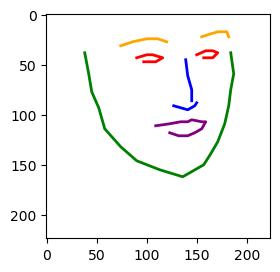

In [12]:
K = 8
rootDir = '../../dataForFewShotTalkingHeadModel/train/mp4/'
outputDir = '../../dataForFewShotTalkingHeadModel/train/output/'
device = 'cpu'
videoList = generateVideoList(rootDir)
fa = FaceAlignment(LandmarksType._2D, device=device)

data = generateKSelectedFramesAndLandmarksForSpecificVideo(K+1, videoList[21], outputDir, fa)

In [ ]:

for i in range(8):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(data[i]['frame'])
    ax2.imshow(data[i]['landmarks'])

In [6]:
data[0]["personId"]

0